In [1]:
import quandl
import pandas as pd
import numpy as np
import datetime
from xgboost import XGBRegressor
from sklearn import preprocessing, cross_validation, svm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
quandl.ApiConfig.api_key = 'DEN8cmx6MYrtzyeUdDeh'
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
ticker = 'AMZN'
df = quandl.get('WIKI/'+ticker)
C = pd.DataFrame(columns=['Pred','Date'])

In [3]:
for j in range(60):
    I = df.iloc[-500-j-1:-j-1]
    func = ['mean','std','skew','kurt']
    time = [2,4,7,30,60,120,250]
    Z = pd.DataFrame()
    for f in func:
        for t in time:
            aux = pd.DataFrame()
            for i in range(249):
                aux[I.index[i+251]] = list(I.iloc[i-t+251:i+251]['Adj. Close'])
            Z[f+str(t)] = aux.apply(f,axis=0)  
    Z.drop(['skew2','kurt2'],axis=1, inplace =True)
    W = pd.merge(Z, I[['Adj. Close']],left_index=True,right_index=True)
    X = W.drop(['Adj. Close'],1).fillna(0)
    y = W[['Adj. Close']]
    A = pd.DataFrame()
    for f in func:
        for t in time:
            aux = pd.DataFrame()
            i = 250
            aux[0] = list(I.iloc[i-t+250:i+251]['Adj. Close'])
            A[f+str(t)] = aux.apply(f,axis=0)
    A.drop(['skew2','kurt2'],axis=1, inplace =True)
    mm1 = MinMaxScaler()
    mm2 = MinMaxScaler()
    mm1.fit(X)
    mm2.fit(y)
    Xm = pd.DataFrame(mm1.transform(X))
    ym = pd.DataFrame(mm2.transform(y))
    model = XGBRegressor()
    model.fit(Xm,ym)
    pred = mm2.inverse_transform(pd.DataFrame(model.predict(pd.DataFrame(mm1.transform(A)))))
    C = C.append({'Date':df.iloc[-j-2:-j-1].index[0],'Pred':float(pred)},ignore_index=True) 

In [4]:
C.index = C['Date']
C = C.drop(['Date'],axis=1)
C = pd.merge(C,df[['Adj. Close']],left_index=True,right_index=True)
C = C.rename({'Adj. Close':'Real'},axis =1)
C = C.reindex(index=C.index[::-1])
Cp = C.pct_change()
N = [C['Real'][0]]
for i in C.index:
    if i == C.index[0]:
        continue 
    if Cp.loc[i]['Pred'] > 0: 
        N.append(N[-1]*(1+Cp.loc[i]['Real']))
    else:
        N.append(N[-1])
C['Boost'] = pd.Series(N).values
C.head()

,Pred,Real,Boost
Date,,,
2017-12-28,1176.326353,1186.10,1186.100000
2017-12-29,1174.276631,1169.47,1186.100000
2018-01-02,1168.487243,1189.01,1186.100000
2018-01-03,1191.596195,1204.20,1201.252824
2018-01-04,1196.912662,1209.59,1206.629632


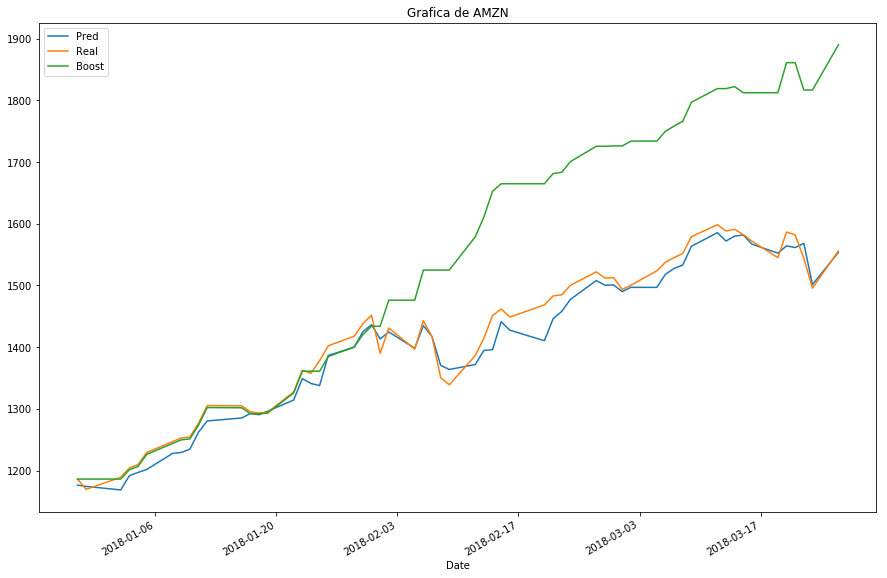

In [7]:
C.plot(figsize = (15,10),title='Grafica de {}'.format(ticker))